In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pymc3 as pm
from tqdm import tqdm

In [111]:
import numpy as np
import scipy
import scipy.stats as sc
import matplotlib as mpl   
import matplotlib.pyplot as plt
import itertools 

In [3]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

We will show how to estimate regression parameters using a simple linear modesl

y∼ax+b
We can restate the linear model

y=ax+b+ϵ
as sampling from a probability distribution

y∼ N(ax+b,σ2)

Now we can use pymc to estimate the paramters a, b and σ 

+ a∼ N(0,100)
+ b∼ N(0,100)
+ σ ∼Gamma(0.1,0.1)

In [377]:
# observed data
n = 100
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)


In [379]:
# x

In [7]:
niter = 1000

logp = -155.64, ||grad|| = 0.00052274: 100%|██████████| 22/22 [00:00<00:00, 2199.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2693.48draws/s]


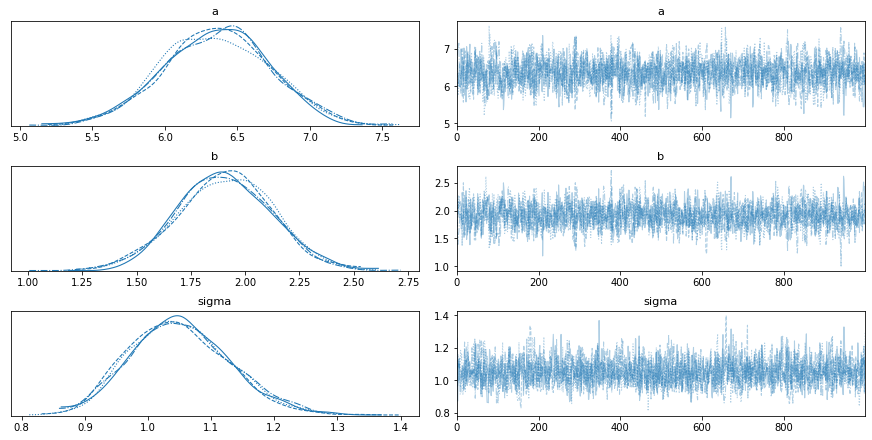

In [8]:
with pm.Model() as model:
    
    #Prior distributions
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    
    
    #std of y
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    #sigma = 2
    
    
    #mean of y_hat
    y_est = a*x + b # simple auxiliary variables
    
    #defining the likelihood function
    likelihood = pm.Normal('y', mu= y_est, sd = sigma, observed = y)
    
    
    #inference
    start = pm.find_MAP()
    step = pm.NUTS() # Mtropolis MCMC with No U-Turn Sampler
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    pm.traceplot(trace);

#### Bayesian Linear Regression with Gibbs Sampling

Ref : https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

#### Updates for intercept_c

In [9]:
def get_intercept_c(y, x, b, t, c0, tc):
    n = len(y)
    assert len(x) == n
    precision = c0 + t * n
    mean = tc * c0 + t * np.sum(y - b * x)
    mean = mean/precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

#### Updates for slope_b

In [10]:
def get_slope_b(y, x, c, t, b0, tb):
    n = len(y)
    assert len(x) == n
    precision = tb + t * np.sum(x * x)
    mean = tb * b0 + t * np.sum( (y - c) * x)
    mean = mean/precision
    return np.random.normal(mean, 1 / np.sqrt(precision))


#### Updates for precision_t

In [11]:
def get_precision_t(y, x, b, c, alpha, beta):
    n = len(y)
    alpha_new = alpha + n / 2
    resid = y - c - b * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

#### Synthetic Data Generation

Text(0, 0.5, 'y')

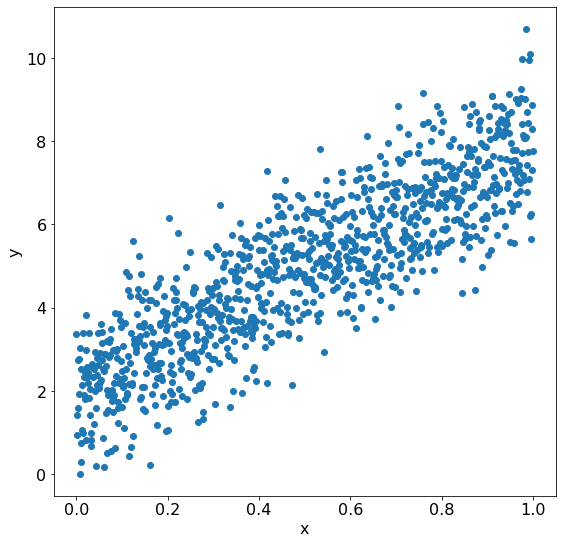

In [28]:
# observed data
n = 1000
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

#### Initializing the parameters

In [29]:
## specify initial values
init = {"c": 0,
        "b": 0,
        "t": 2}

## specify hyper parameters
hypers = {"c0": 0,
         "tc": 1,
         "b0": 0,
         "tb": 1,
         "alpha": 2,
         "beta": 1}

In [30]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    c = init["c"]
    b = init["b"]
    t = init["t"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of b, c, t
    
    for it in tqdm(range(iters)):
        c = get_intercept_c(y, x, b, t, hypers["c0"], hypers["tc"])
        b = get_slope_b(y, x, c, t, hypers["b0"], hypers["tb"])
        t = get_precision_t(y, x, b, c, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((c, b, t))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['intercept', 'slope', 'precision']
        
    return trace

In [31]:
iters = 15000
trace = gibbs(y, x, iters, init, hypers)

100%|██████████| 15000/15000 [00:00<00:00, 16035.92it/s]


Text(0, 0.5, 'Parameter value')

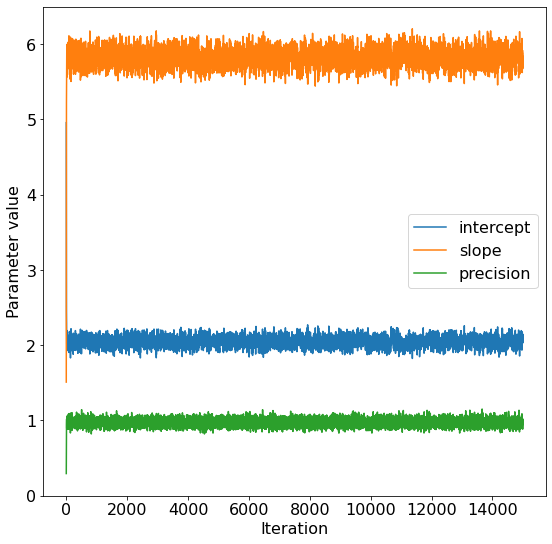

In [32]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

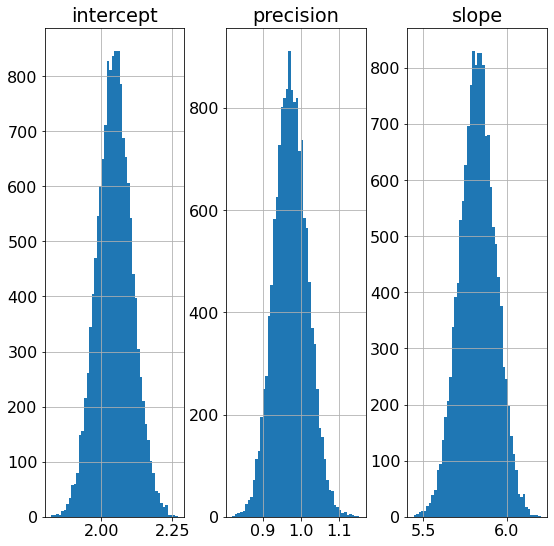

In [33]:
trace_burnt = trace[500:14999]
hist_plot = trace_burnt.hist(bins = 50, layout = (1,3))

In [34]:
print(trace_burnt.median())
print(trace_burnt.std())

intercept    2.046434
slope        5.826273
precision    0.972057
dtype: float64
intercept    0.062107
slope        0.108225
precision    0.043740
dtype: float64
